# SAMPLE RUN - C01-C06 best run

- Environment: PHM
- Training: PHM_C01
- Evaluation: PHM_C06
- Algo: PPO
- Rewards: ```r1 = 1; r2 = -20; r3 = -3```
- Episodes: 200k
- Noise: 1/500
- Sampling rate: 25

### Colab

<!-- - Colab vVe: S:: ```2.3.2``, gy: ```0.29.1``
- x 
3. ```max_episode_steps = 10*MILLING_OPERATIONS_MA
- x 
4. ```EARLY_DETECT_FACTOR = 0.1
- x `
5. ```r1 = 1; r2 = -4; r3 = - -->0.5```

**To-do**:
1. Download TB plots: [link](https://stackoverflow.com/questions/51079373/automatically-save-tensorboard-like-plot-of-loss-to-image-file)

## RL for Predictive Maintenance
- V.0.5 08-Nov-2024:
    - Rewards are now time related
    - Replacing too early. Add ```EARLY_DETECT_FACTOR = 0.125``` and ```
r1 = 1; r2 = -4; r3 = -0.```
 
**Settings**:
1. Sample rate: 25 i.e. about 40 records
3. Gym Env. termination: ```max_episode_steps = MAX_EPISODE_STEPS_FACTOR * number_of_records``` and set ```MAX_EPISODE_STEPS_FACTOR = 10```
   
**Rewards**:
1. R1 = Forward time-step, R2 = RUL threshold breached, R3 = Tool replacement cost
2. First working: ```r1 = 1; r2 = -4, r3 = -0.5``` >> Eps 30k. Rewards stable but actual replacements NOT correct or practical 
3. Second working: ```r1 = 1; r2 = -3; r3 = -5``` >> Eps 80k. Better. But replacements still NOT correct
4. Current R&D: ```r1 = 1; r2 = -100; r3 = -5``` >> Eps 80k. 


In [1]:
EARLY_DETECT_FACTOR = -0.125
r1 = 1; r2 = -4; r3 = -0.5
r1, r2, r3

(1, -4, -0.5)

## Milling Tool Environment

In [2]:
# Milling Tool Environment
# - Handles multiple dataset. PHM and NUAA
# - Default Rewards: ```R1: +1.0, R2: -4.0, R3: -0.5```

import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

NO_ACTION = 0
REPLACE = 1

class Milling_Tool_Env(gym.Env):
    
        def __init__(self, max_records=0, env_type = '', rul_threshold=0.0, R1=1.0, R2=0.0, R3=0.0):
            print(f'-- Ver. RB 0.5. Tested 26-Nov-24: Environment: {env_type} | RUL threshold: {rul_threshold:4.3f} | Records: {max_records} | R1: {R1:3.1f}, R2: {R2:3.1f}, R3: {R3:3.1f}')

            # Initialize
            self.env_type = env_type
            self.R1 = R1
            self.R2 = R2
            self.R3 = R3
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            self.a_rewards = []
            self.a_actions = []
            self.a_action_recommended = []
            self.a_rul = []
            self.a_time_since_last_replacement = []

            self.df = None
            self.current_time_step = 0
            self.max_records = max_records
            self.maintenance_cost = 0.0
            self.replacement_events = 0
            self.time_since_last_replacement = 0
            self.rul_threshold = rul_threshold

            high = np.array(6*[1.0], dtype=np.float32)
            low = np.array(6*[-1.0], dtype=np.float32)
            self.observation_space = spaces.Box(low, high, dtype=np.float32)
            self.action_space = spaces.Discrete(2)

        ## Add tool wear data-set
        ## Keep rul_threshold intialized to self.rul_threshold
        def tool_wear_data(self, df, rul_threshold=0.0):
            self.df = df
            self.rul_threshold = rul_threshold
            self.max_records = len(df.index)
            print(f'   * Tool-wear data updated: {self.max_records}. RUL threshold: {self.rul_threshold:4.3f}')

        def _get_observation(self):
            if (self.df is not None):
                if (self.env_type == 'PHM'):
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'force_x'],
                        self.df.loc[self.current_time_step, 'force_y'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration_z']
                    ], dtype=np.float32)
                else:
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'axial_force'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration1'],
                        self.df.loc[self.current_time_step, 'vibration2']
                    ], dtype=np.float32)
            else:
                obs_values = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

            observation = obs_values.flatten()
            return observation

        def _get_auxilliary_info(self):
            if (self.df is not None):
                recommended_action = int(self.df.loc[self.current_time_step, 'ACTION_CODE'])
                rul = float(self.df.loc[self.current_time_step, 'RUL'])
            else:
                recommended_action = 0
                rul = 0.0

            return recommended_action, rul

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            # self.a_rewards = []
            # self.a_actions = []
            # self.a_action_recommended = []
            # self.a_rul = []

            # Choose the tool wear at a random time (spatial) location from a uniformly random distribution
            # self.current_time_step = np.random.randint(0, int(RANDOM_TOOL_START_OF_LIFE * self.max_records), 1, dtype=int)
            self.current_time_step = 0
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            observation = self._get_observation()
            info = {'reset':'Reset'}
            return observation, info

        ## Step
        def step(self, action):
            terminated = False
            reward = 0.0
            info = {'Step':'-'}
            # Get auxilliary info: current RUL reading (note this is NOT part of the observation) and the expert's recommended action
            recommended_action, self.rul = self._get_auxilliary_info()
            self.maintenance_cost = 0.0

            # Check if Episode over
            if self.current_time_step >= self.max_records:
                done = True

            # Reward for RUL maximized and penalize if breached
            if self.rul > (1.0+EARLY_DETECT_FACTOR)*self.rul_threshold:
                reward = self.current_time_step*self.R1
            else:
                reward = self.current_time_step*self.R2

            # If tool replaced, add cost of replacement
            if action == REPLACE:
                # Update time_since_last_replacement
                self.time_since_last_replacement = self.current_time_step
                self.a_time_since_last_replacement.append(self.current_time_step)
                reward = self.current_time_step*self.R3
                self.current_time_step = 0

            self.reward = reward
            self.cummulative_rewards = self.cummulative_rewards + reward

            # Information arrays
            self.a_rewards.append(reward)
            self.a_actions.append(action)
            self.a_action_recommended.append(recommended_action)
            self.a_rul.append(self.rul)

            if (action != REPLACE) and (self.current_time_step < (self.max_records-1)):
              self.current_time_step += 1

            # Action taken, reward set for that action, now take in next observation
            observation = self._get_observation()


            if self.rul <= self.rul_threshold:
              self.cummulative_rewards = 0.0

            # if self.rul > self.rul_threshold:
            #     print(f'Action>> Expert:{recommended_action:2d} Agent:{action:2d}| RUL: {self.rul:>5.2f} | Reward: {reward:>7.2f} -- CR: {self.cummulative_rewards:>7.2f}' )
            # else:
            #     print(f'*** RUL reached: {self.rul:3.2f} ***')
            #     self.cummulative_rewards = 0.0

            # writer.add_scalar('reward', reward)
            return observation, self.reward, terminated, False, info

## Libraries, Paths, Data-sets

In [3]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# RL libraries
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.tensorboard import SummaryWriter

# Custom libraries
from utilities import downsample, tool_wear_data

# Data-sets
datasets = {'NUAA_W1':['NUAA_W1_0p229.csv', 0.229], 'NUAA_W3':['NUAA_W3_0p12.csv', 0.12], 'NUAA_W8':['NUAA_W8_0p281.csv', 0.281],
           'PHM_C01':['PHM_C01_0p12.csv', 0.12],  'PHM_C04':['PHM_C04_0p098.csv', 0.098],  'PHM_C06':['PHM_C06_0p13.csv', 0.13]}

# Paths
dt_string = datetime.now().strftime("%d-%b-%Y  %H:%M:%S")
PATH = 'D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance'
DATA_PATH = f'{PATH}/Data/'

In [4]:
import stable_baselines3, gymnasium
print('stable_baselines3: ', stable_baselines3.__version__)
print('gymnasium: ', gymnasium.__version__)

stable_baselines3:  2.3.2
gymnasium:  0.29.1


## Set-up

In [5]:
# Environment set-up
ENV_TYPE = 'PHM' # PHM NUAA
TRAINING_DATA = f'{ENV_TYPE}_C01' # C01, C04, C06, W1, W3, W8 
EVALUATION_DATA = f'{ENV_TYPE}_C04'
ADD_NOISE = 5*1e2
SAMPLING_RATE = 25

# RL set-up
EPISODES = int(200)
ALGO = 'PPO'
BATCH_SIZE = 16
EVALUATION_ROUNDS = 20
TENSOR_BOARD = True
PRETRAINED_MODEL = False 
MAX_EPISODE_STEPS_FACTOR = 10 # MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records

# Set-up data-sets
DATA_FILE = datasets[TRAINING_DATA][0]
WEAR_THRESHOLD = datasets[TRAINING_DATA][1]
TEST_DATA = datasets[EVALUATION_DATA][0]
TEST_WEAR_THRESHOLD = datasets[EVALUATION_DATA][1]

# Paths
DATA_FILE = f'{DATA_PATH}/{DATA_FILE}'
TEST_DATA_FILE = f'{DATA_PATH}/{TEST_DATA}'
mfile = f'Agent_{TRAINING_DATA}_Eps_{EPISODES}_Noise_{ADD_NOISE}_R1_{r1}_R2_{r2}_R3_{r3}'
mfile = mfile.replace('.', 'p')
MODEL_FILE = f'{PATH}/models/{mfile}'
LOG_PATH = f'{PATH}/tensorboard/{TRAINING_DATA}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'TRAINING: Data set: {DATA_FILE}, Threshold: {WEAR_THRESHOLD}')
print(f'EVALUATION: Data set: {TEST_DATA}, Threshold: {TEST_WEAR_THRESHOLD}')
print(f'Tensorboard logging to {LOG_PATH}')
print(f'Model {MODEL_FILE}')

TRAINING: Data set: D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/Data//PHM_C01_0p12.csv, Threshold: 0.12
EVALUATION: Data set: PHM_C04_0p098.csv, Threshold: 0.098
Tensorboard logging to D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/tensorboard/PHM_C01/
Model D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/models/Agent_PHM_C01_Eps_200_Noise_500p0_R1_1_R2_-4_R3_-0p5


In [6]:
# from packaging import version

# import pandas as pd
# from matplotlib import pyplot as plt
# import seaborn as sns
# from scipy import stats
# import tensorboard as tb

# major_ver, minor_ver, _ = version.parse(tb.__version__).release
# assert major_ver >= 2 and minor_ver >= 3, \
#     "This notebook requires TensorBoard 2.3 or later."
# print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.18.0


In [7]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# acc = EventAccumulator('D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/tensorboard/PHM_C01/events.out.tfevents.1731049286.DESKTOP-QNF0D7G.13840.0')
# acc.Reload()
# acc.Tags()

In [8]:
# pd.DataFrame(acc.Scalars("Test Loss"))

In [9]:
# # Tensorboard visualization
# # https://www.tensorflow.org/tensorboard/dataframe_api

# # Filter the DataFrame to only validation data, which is what the subsequent
# # analyses and visualization will be focused on.
# dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# # Get the optimizer value for each row of the validation DataFrame.
# optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

# plt.figure(figsize=(16, 6))
# plt.subplot(1, 2, 1)
# sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
#              hue=optimizer_validation).set_title("accuracy")
# plt.subplot(1, 2, 2)
# sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
#              hue=optimizer_validation).set_title("loss")

In [10]:
# pd.read_csv('PHM_C01_ep_rew_mean.csv')

## Tool wear data

- Down-sampling. Input data records: 1022. Sampling rate: 25. Expected rows 41.    Down-sampled to 41 rows.


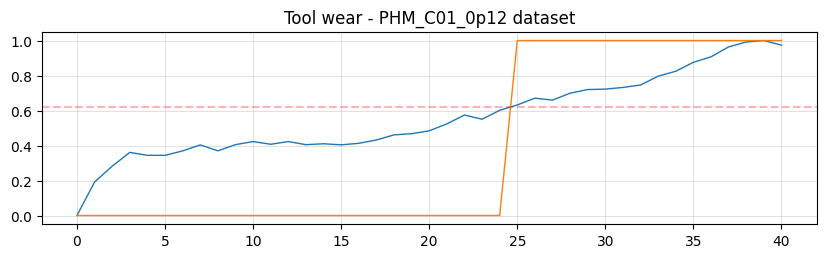

- Down-sampling. Input data records: 1008. Sampling rate: 25. Expected rows 40.    Down-sampled to 41 rows.


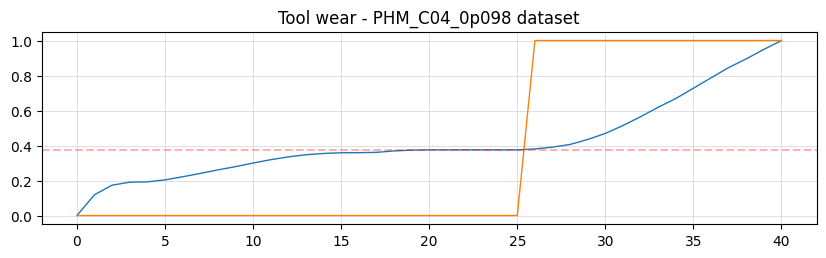

TRAIN - RUL threshold at time 25 is 0.402, and wear threshold 0.120
TEST  - RUL threshold at time 26 is 0.624, and wear threshold 0.098


In [11]:
# Create Training data
_, _, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records
rul_threshold_record_train = df_train.loc[df_train['tool_wear'] >= WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_train = df_train.loc[df_train.index[rul_threshold_record_train], 'RUL']

# Create Test data
_, _, TEST_WEAR_THRESHOLD_NORMALIZED, df_test = tool_wear_data(
    env_type = ENV_TYPE, data_file=TEST_DATA_FILE, wear_threshold = TEST_WEAR_THRESHOLD,
    normalize=True, add_noise=False, sampling_rate = SAMPLING_RATE)

n_test_records = len(df_test.index)
rul_threshold_record_test = df_test.loc[df_test['tool_wear'] >= TEST_WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_test = df_test.loc[df_test.index[rul_threshold_record_test], 'RUL']

print(f'TRAIN - RUL threshold at time {rul_threshold_record_train} is {rul_threshold_train:3.3f}, and wear threshold {WEAR_THRESHOLD:3.3f}')
print(f'TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}, and wear threshold {TEST_WEAR_THRESHOLD:3.3f}')

## Predictive Maintenance Agent Training

In [12]:
from stable_baselines3.common.monitor import Monitor

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = Milling_Tool_Env,
    max_episode_steps = MAX_EPISODE_STEPS,)

mt_env = Monitor(gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train, R1=r1, R2=r2, R3=r3))
# mt_env = gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train)
mt_env.tool_wear_data(df_train, rul_threshold_train)

-- Ver. RB 0.5. Tested 26-Nov-24: Environment: PHM | RUL threshold: 0.402 | Records: 41 | R1: 1.0, R2: -4.0, R3: -0.5
   * Tool-wear data updated: 41. RUL threshold: 0.402


In [13]:
if ALGO == 'PPO':
  expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
  expert_ppo.learn(EPISODES)
elif ALGO == 'A2C':
  expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
  expert_a2c.learn(EPISODES)

In [14]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

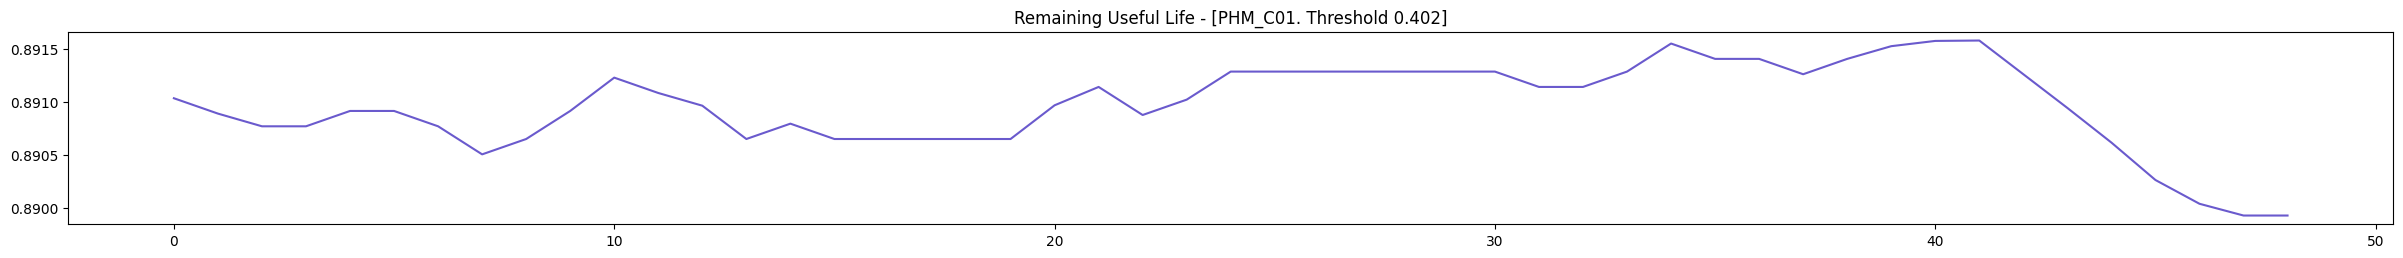

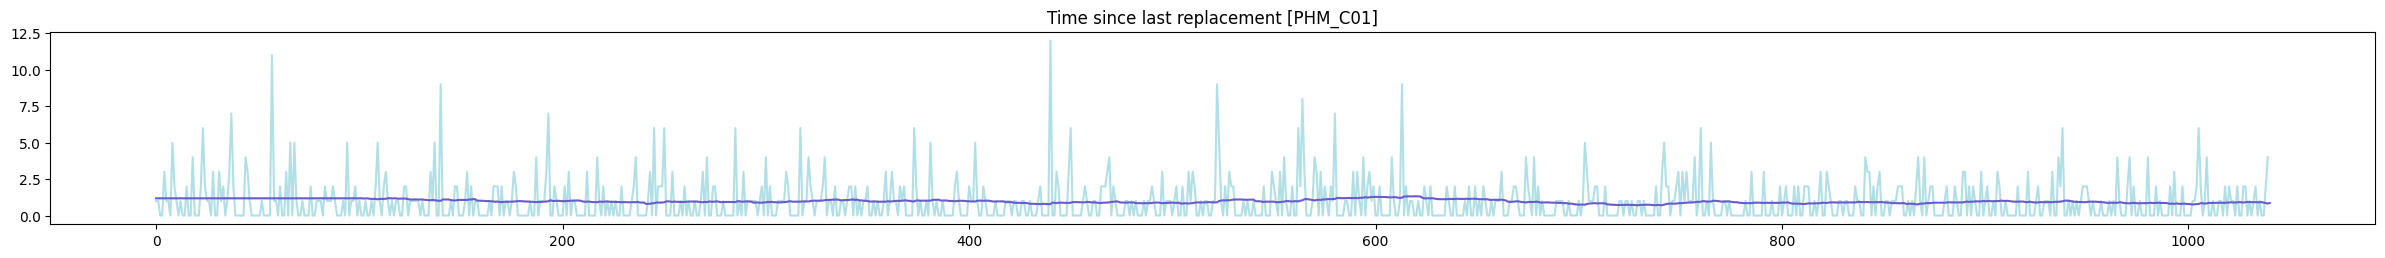

In [15]:
stop_pt = int(1 * len(mt_env.a_rul))
w = 1000
ma_rul = moving_average(mt_env.a_rul[0:stop_pt], w)
# ma_rul = np.pad(ma_rul, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rul[0:stop_pt], 'powderblue', alpha=0.7)
plt.plot(ma_rul[:-w], 'slateblue')
plt.title(f'Remaining Useful Life - [{TRAINING_DATA}. Threshold {rul_threshold_train:4.3f}]')
# plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
# plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
plt.show()

stop_pt = int(1 * len(mt_env.a_time_since_last_replacement))
w = 100
ma_rep_time = moving_average(mt_env.a_time_since_last_replacement[0:stop_pt], w)
ma_rep_time = np.pad(ma_rep_time, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
plt.plot(mt_env.a_time_since_last_replacement[0:stop_pt], 'powderblue')
plt.plot(ma_rep_time[:-w], 'slateblue')
plt.title(f'Time since last replacement [{TRAINING_DATA}]')
plt.show()

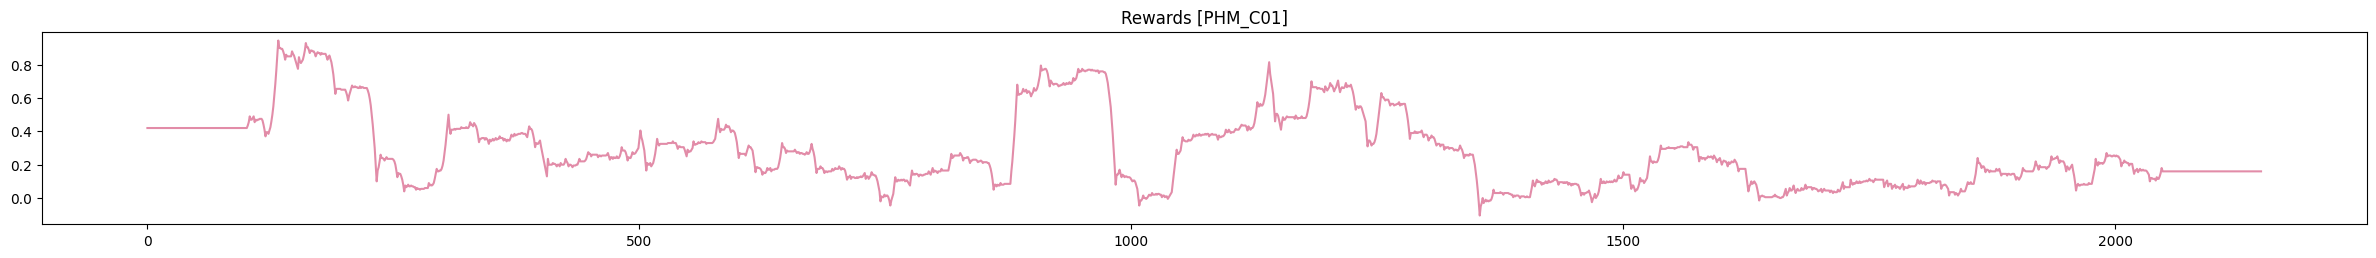

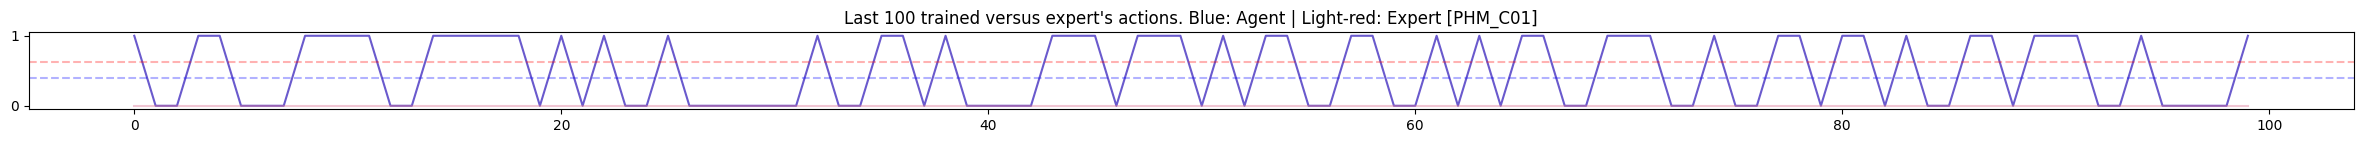

In [16]:
w = 100
l = EPISODES-w

ma_rewards = moving_average(mt_env.a_rewards, w)
ma_rewards = np.pad(ma_rewards, pad_width=w, mode='edge')

plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rewards, alpha=0.1)
plt.plot(ma_rewards, 'palevioletred', alpha=0.8)
plt.title(f'Rewards [{TRAINING_DATA}]')
plt.show()

plt.figure(figsize=(30, 1))
plt.plot(mt_env.a_actions[-w:], 'slateblue')
plt.plot(mt_env.a_action_recommended[-w:], 'palevioletred', alpha=0.4)
plt.title(f'Last {w} trained versus expert\'s actions. Blue: Agent | Light-red: Expert [{TRAINING_DATA}]')
plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
plt.show()

## Agent Testing

In [17]:
# R1=+1.0, R2=-4.0, R3=-0.5
mt_test_env = gym.make('custom/MillingToolEnv-v0', max_records=n_test_records, env_type=ENV_TYPE, rul_threshold=rul_threshold_test, R1=r1, R2=r2, R3=r3)
mt_test_env.tool_wear_data(df_test, rul_threshold_test)

-- Ver. RB 0.5. Tested 26-Nov-24: Environment: PHM | RUL threshold: 0.624 | Records: 41 | R1: 1.0, R2: -4.0, R3: -0.5
   * Tool-wear data updated: 41. RUL threshold: 0.624


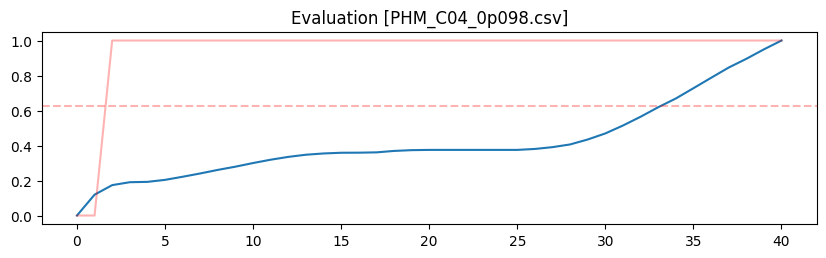

Rewards 1, -4, -0.5. TEST  - RUL threshold at time 26 is 0.624


In [18]:
if ALGO == 'PPO':
    expert = expert_ppo
else:
    expert = expert_a2c
    
obsv = mt_test_env.reset()
# During reset a tuple is returned. So take the state only. When the step() is called it properly returns only the state so obsv will work
obsv = obsv[0]

REPLACED_FLAG = False
eval_rewards = []
eval_action = []
eval_rewards.clear()
eval_action.clear()

for i in range(n_test_records):
    action, _state = expert.predict(obsv)
    _, reward, done, info, _ = mt_test_env.step(action)

    if (ENV_TYPE == 'PHM'):
        obs_values = np.array([df_test.loc[i, 'force_x'], df_test.loc[i, 'force_y'], df_test.loc[i, 'force_z'],
                            df_test.loc[i, 'vibration_x'], df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration_z']], dtype=np.float32)
    else:
        obs_values = np.array([df_test.loc[i, 'axial_force'], df_test.loc[i, 'force_z'], df_test.loc[i, 'vibration_x'],
                            df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration1'], df_test.loc[i, 'vibration2']], dtype=np.float32)

    obsv = obs_values.flatten()
    eval_rewards.append(reward)
    # eval_action.append(action)

    if (not REPLACED_FLAG):
        if (action == REPLACE):
            eval_action.append(1)
            REPLACED_FLAG = True
        else:
            eval_action.append(action)    
    else:
        eval_action.append(1)

plt.figure(figsize=(10, 2.5))
plt.plot(df_test['tool_wear'])
plt.plot(eval_action, 'r', alpha=0.3)
plt.axhline(y = rul_threshold_test, color = 'r', linestyle = '--', alpha=0.3) 
# plt.plot(eval_rewards, 'b', alpha=0.4)
plt.title(f'Evaluation [{TEST_DATA}]')
plt.show()
print(f'Rewards {r1}, {r2}, {r3}. TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}')

## Set-up new test data

- Down-sampling. Input data records: 1022. Sampling rate: 25. Expected rows 41.    Down-sampled to 41 rows.


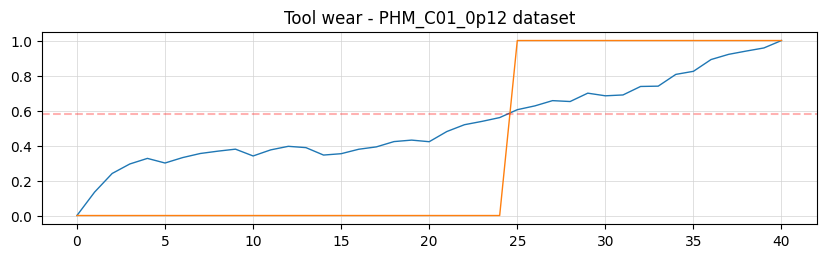

- Down-sampling. Input data records: 1008. Sampling rate: 25. Expected rows 40.    Down-sampled to 41 rows.


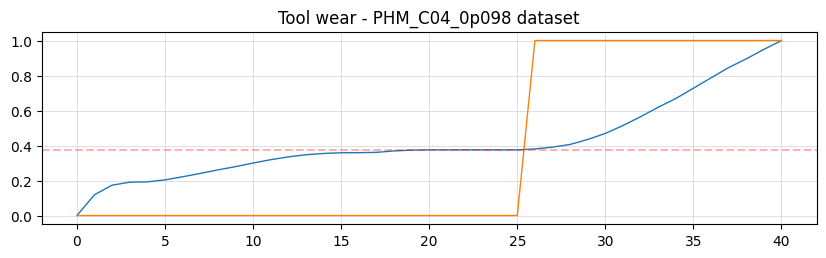

TRAIN - RUL threshold at time 25 is 0.402, and wear threshold 0.120
TEST  - RUL threshold at time 26 is 0.624, and wear threshold 0.098
-- Ver. RB 0.5. Tested 26-Nov-24: Environment: PHM | RUL threshold: 0.624 | Records: 41 | R1: 1.0, R2: -4.0, R3: -0.5
   * Tool-wear data updated: 41. RUL threshold: 0.624


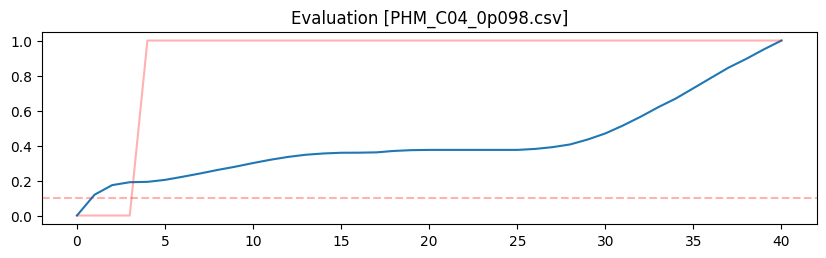

Rewards 1, -4, -0.5. TEST  - RUL threshold at time 26 is 0.624


In [23]:
TRAINING_DATA = f'{ENV_TYPE}_C01' # C01, C04, C06, W1, W3, W8 
EVALUATION_DATA = f'{ENV_TYPE}_C04'

# Set-up data-sets
DATA_FILE = datasets[TRAINING_DATA][0]
WEAR_THRESHOLD = datasets[TRAINING_DATA][1]
TEST_DATA = datasets[EVALUATION_DATA][0]
TEST_WEAR_THRESHOLD = datasets[EVALUATION_DATA][1]


# Paths
DATA_FILE = f'{DATA_PATH}/{DATA_FILE}'
TEST_DATA_FILE = f'{DATA_PATH}/{TEST_DATA}'
# print(f'TRAINING: Data set: {DATA_FILE}, Threshold: {WEAR_THRESHOLD}')
# print(f'EVALUATION: Data set: {TEST_DATA}, Threshold: {TEST_WEAR_THRESHOLD}')

# Create Training data
_, _, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records
rul_threshold_record_train = df_train.loc[df_train['tool_wear'] >= WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_train = df_train.loc[df_train.index[rul_threshold_record_train], 'RUL']

# Create Test data
_, _, TEST_WEAR_THRESHOLD_NORMALIZED, df_test = tool_wear_data(
    env_type = ENV_TYPE, data_file=TEST_DATA_FILE, wear_threshold = TEST_WEAR_THRESHOLD,
    normalize=True, add_noise=False, sampling_rate = SAMPLING_RATE)

n_test_records = len(df_test.index)
rul_threshold_record_test = df_test.loc[df_test['tool_wear'] >= TEST_WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_test = df_test.loc[df_test.index[rul_threshold_record_test], 'RUL']

print(f'TRAIN - RUL threshold at time {rul_threshold_record_train} is {rul_threshold_train:3.3f}, and wear threshold {WEAR_THRESHOLD:3.3f}')
print(f'TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}, and wear threshold {TEST_WEAR_THRESHOLD:3.3f}')

# R1=+1.0, R2=-4.0, R3=-0.5
mt_test_env = gym.make('custom/MillingToolEnv-v0', max_records=n_test_records, env_type=ENV_TYPE, rul_threshold=rul_threshold_test, R1=r1, R2=r2, R3=r3)
mt_test_env.tool_wear_data(df_test, rul_threshold_test)

obsv = mt_test_env.reset()
# During reset a tuple is returned. So take the state only. When the step() is called it properly returns only the state so obsv will work
obsv = obsv[0]

REPLACED_FLAG = False
eval_rewards = []
eval_action = []
eval_rewards.clear()
eval_action.clear()

for i in range(n_test_records):
    action, _state = expert.predict(obsv)
    _, reward, done, info, _ = mt_test_env.step(action)

    if (ENV_TYPE == 'PHM'):
        obs_values = np.array([df_test.loc[i, 'force_x'], df_test.loc[i, 'force_y'], df_test.loc[i, 'force_z'],
                            df_test.loc[i, 'vibration_x'], df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration_z']], dtype=np.float32)
    else:
        obs_values = np.array([df_test.loc[i, 'axial_force'], df_test.loc[i, 'force_z'], df_test.loc[i, 'vibration_x'],
                            df_test.loc[i, 'vibration_y'], df_test.loc[i, 'vibration1'], df_test.loc[i, 'vibration2']], dtype=np.float32)

    obsv = obs_values.flatten()
    eval_rewards.append(reward)
    # eval_action.append(action)

    if (not REPLACED_FLAG):
        if (action == REPLACE):
            eval_action.append(1)
            REPLACED_FLAG = True
        else:
            eval_action.append(action)    
    else:
        eval_action.append(1)

plt.figure(figsize=(10, 2.5))
plt.plot(df_test['tool_wear'])
plt.plot(eval_action, 'r', alpha=0.3)
plt.axhline(y = TEST_WEAR_THRESHOLD, color = 'r', linestyle = '--', alpha=0.3) 
# plt.plot(eval_rewards, 'b', alpha=0.4)
plt.title(f'Evaluation [{TEST_DATA}]')
plt.show()
print(f'Rewards {r1}, {r2}, {r3}. TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}')

## Model save

In [20]:
MODEL_FILE = MODEL_FILE.replace('.', 'p')
print(f'- Saving Expert model in {MODEL_FILE}')
# fp = 'Agent_PHM_C01_Eps_300k_Noise_500_R1_1_R2_-2_R3_-0p5'
expert.save(MODEL_FILE)
# print(f'- Loading pre-tranined {ALGO} Expert model from {MODEL_FILE}')
# expert = PPO.load(MODEL_FILE)

- Saving Expert model in D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/models/Agent_PHM_C01_Eps_200_Noise_500p0_R1_1_R2_-4_R3_-0p5
